## Train Unet on Pix3D mask

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("..")

In [33]:
args = {
    'config': 'configs/encoder/pix3d_unet.yaml',
    'no_cuda': True,
    'exit_after': -1
}

In [34]:
import torch
import torch.optim as optim
from tensorboardX import SummaryWriter
import numpy as np
import os
import argparse
import time
import matplotlib; matplotlib.use('Agg')
from im2mesh import config, data
from im2mesh.checkpoints import CheckpointIO

In [35]:
import matplotlib.pyplot as plt
from torchvision.transforms import transforms

In [36]:
cfg = config.load_config(args["config"], 'configs/default.yaml')
is_cuda = (torch.cuda.is_available() and not args["no_cuda"])
device = torch.device("cuda" if is_cuda else "cpu")

In [37]:
# Shorthands
out_dir = cfg['training']['out_dir']
batch_size = cfg['training']['batch_size']
backup_every = cfg['training']['backup_every']
exit_after = args["exit_after"]

In [38]:
model_selection_metric = cfg['training']['model_selection_metric']
if cfg['training']['model_selection_mode'] == 'maximize':
    model_selection_sign = 1
elif cfg['training']['model_selection_mode'] == 'minimize':
    model_selection_sign = -1
else:
    raise ValueError('model_selection_mode must be '
                     'either maximize or minimize.')

In [39]:
# Output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [40]:
cfg

{'method': 'autoencoder',
 'data': {'dataset': 'Pix3D',
  'path': 'data/pix3d',
  'classes': ['chair'],
  'input_type': 'img',
  'train_split': 'train',
  'val_split': 'val',
  'test_split': 'test',
  'dim': 3,
  'points_file': 'points.npz',
  'points_iou_file': 'points.npz',
  'points_subsample': 1024,
  'points_unpackbits': True,
  'model_file': 'model.off',
  'watertight_file': 'model_watertight.off',
  'img_folder': 'img',
  'img_size': 224,
  'img_with_camera': False,
  'img_augment': True,
  'img_ext': 'jpg',
  'bg_augment': 1.0,
  'bg_folder': 'data/indoor_images',
  'scale_limit': 0.0,
  'n_views': 24,
  'pointcloud_file': 'pointcloud.npz',
  'pointcloud_chamfer_file': 'pointcloud.npz',
  'pointcloud_n': 256,
  'pointcloud_target_n': 1024,
  'pointcloud_noise': 0.05,
  'voxels_file': 'model.binvox',
  'with_transforms': False,
  'with_gt': False},
 'model': {'decoder': 'simple',
  'encoder': 'uresnet18',
  'encoder_latent': None,
  'decoder_kwargs': {},
  'encoder_kwargs': {},


In [41]:
# Dataset
train_dataset = config.get_dataset('train', cfg)
val_dataset = config.get_dataset('val', cfg)

### Train

In [42]:
len(train_dataset)

3071

#### Train input

In [43]:
sample = train_dataset[np.random.randint(0, len(train_dataset))]

In [44]:
transforms.ToPILImage()(batch['inputs'][3])

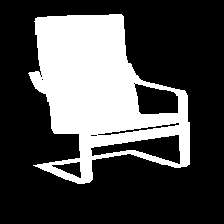

In [45]:
transforms.ToPILImage()(batch['inputs.gt'][3])

### Data loader

In [46]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=2, shuffle=True,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn)

In [47]:
batch = next(iter(train_loader))

In [48]:
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=10, num_workers=2, shuffle=False,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn
)

In [49]:
vis_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=12, shuffle=True,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn,
)

In [50]:
vis_batch = next(iter(vis_loader))

### Model

In [51]:
model = config.get_model(cfg, device=device, dataset=train_dataset)

In [52]:
nparams = sum(p.numel() for p in model.parameters())
print(nparams)

31120851


In [53]:
from torchsummary import torchsummary
torchsummary.summary(model, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [69]:
model[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [54]:
optimizer = config.get_optimizer(model, cfg)

In [55]:
checkpoint_io = CheckpointIO(out_dir, model=model, optimizer=optimizer)

In [56]:
logger = SummaryWriter(os.path.join(out_dir, 'logs'))

In [489]:
trainer = config.get_trainer(model, optimizer, logger, cfg, device=device)

In [530]:
model.eval()
with torch.no_grad():
    loss = trainer.compute_loss(batch)
print(loss)

tensor(1.8127e+10)


In [37]:
trainer.visualize(vis_batch)

100%|██████████| 12/12 [00:00<00:00, 20.19it/s]


In [38]:
output = model(batch['inputs'])

In [39]:
output[0].max()

tensor(-0.8603, grad_fn=<MaxBackward1>)